In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle

from pathlib import Path

import motorlab as ml
import numpy as np
import seaborn as sns
import yaml

In [3]:
os.chdir(Path().resolve().parent)

In [4]:
x_size, y_size = ml.room.get_size()
num_x_divs, num_y_divs = ml.room.get_divisions()

target_location = {
    "homing": (x_size / 2, 0.0),
    "L": (x_size / num_x_divs / 2, y_size),
    "R": (x_size - x_size / num_x_divs / 2, y_size),
}

### eval

##### old gbyk

In [5]:
runs_architectures = {
    "linear_regression": 20250819231449,
}

In [25]:
runs_pca = {
    "all": 20250820203533,
    "loose": 20250820204845,
    "medium": 20250820210428,
    "strict": 20250820211643,
    "draconian": 20250820212632,
    "adversarial": 20250822062312,
}

In [26]:
results = {
    "rmse": [],
    "accuracy (x-axis)": [],
    "accuracy (y-axis)": [],
    "representation": [],
    "interval_type": [],
    "monkey": [],
}

for representation, run in runs_pca.items():
    cfg_path = Path(f"artifacts/poses_to_location/{run}/config.yml")
    with open(cfg_path, "r") as f:
        cfg = yaml.safe_load(f)

    predictions_path = Path(
        f"artifacts/poses_to_location/{run}/predictions.pkl"
    )
    with open(predictions_path, "rb") as f:
        predictions = pickle.load(f)

    for session in cfg["sessions"]:
        session_dir = Path(cfg["data"]["dir"]) / cfg["experiment"] / session
        intervals = ml.intervals.load_as_df(
            session_dir,
            sampling_rate=cfg["data"]["sampling_rate"],
        )

        for gt, pred in zip(
            predictions["gts"][session]["location"],
            predictions["preds"][session]["location"],
        ):
            rmse = np.sqrt(np.mean((gt - pred) ** 2))
            results["rmse"].append(rmse)
            gt_tiles = ml.room.compute_tiles(gt[:, 0], gt[:, 1])
            pred_tiles = ml.room.compute_tiles(pred[:, 0], pred[:, 1])
            results["accuracy (x-axis)"].append(
                ml.metrics.balanced_accuracy(gt_tiles, pred_tiles, group_by="x")
            )
            results["accuracy (y-axis)"].append(
                ml.metrics.balanced_accuracy(
                    gt_tiles, pred_tiles, group_by="y", include_sitting=False
                )
            )
            results["representation"].append(
                cfg["data"]["modalities"]["poses"]["representation"]
            )
            results["interval_type"].append(intervals.iloc[0]["type"])
            results["monkey"].append(session.split("_")[0])

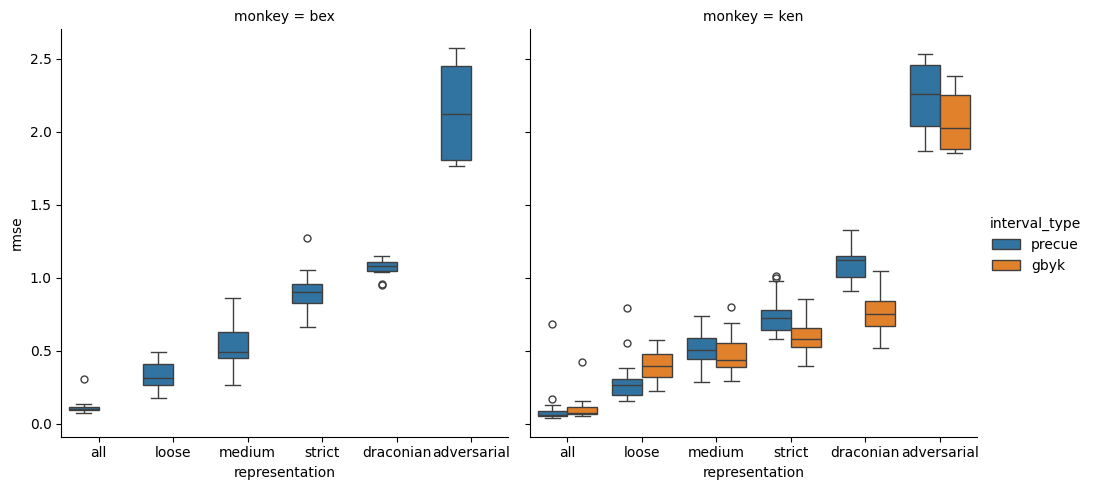

In [24]:
sns.catplot(
    data=results,
    x="representation",
    y="rmse",
    hue="interval_type",
    col="monkey",
    kind="box",
)

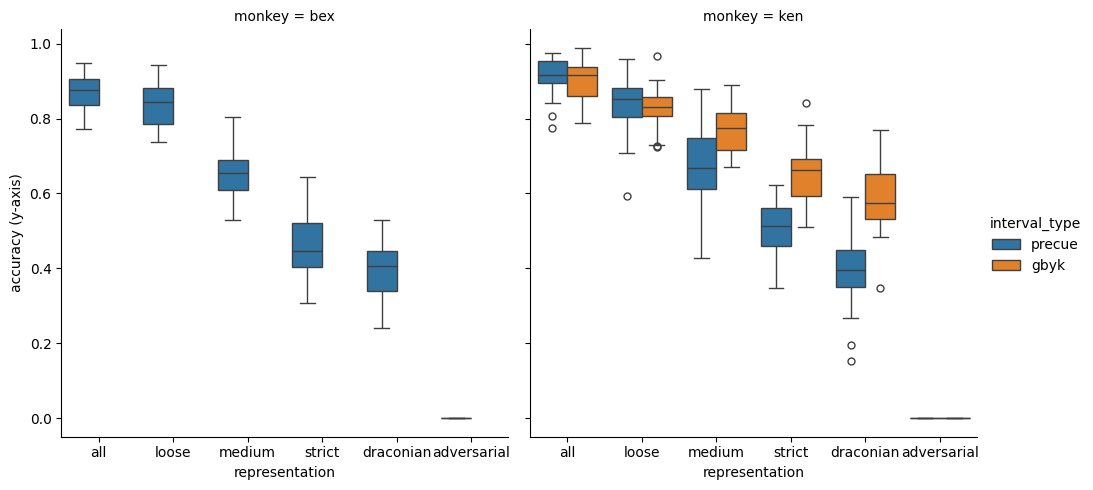

In [22]:
sns.catplot(
    data=results,
    x="representation",
    y="accuracy (y-axis)",
    hue="interval_type",
    col="monkey",
    kind="box",
)

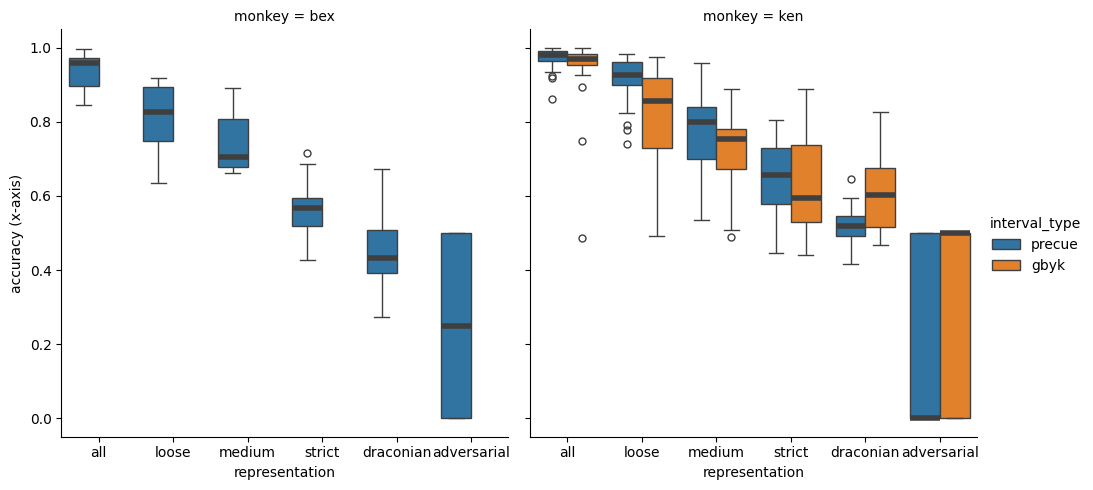

In [23]:
sns.catplot(
    data=results,
    x="representation",
    y="accuracy (x-axis)",
    hue="interval_type",
    col="monkey",
    kind="box",
    medianprops={"linewidth": 4},
)